<a href="https://colab.research.google.com/github/FelipeTufaile/customer_lifetime_value/blob/main/notebooks/Feature_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Dependencies

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [908 kB]
Ign:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get

'/usr/local/lib/python3.10/dist-packages/pyspark'

## Loading Libraries

In [2]:
# Importing Numpy library
import numpy as np

# Importing Pandas library
import pandas as pd

# Importing datetime library
from datetime import datetime, timedelta

# Importing plotying libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing userdata from Google Colab Library
from google.colab import userdata

# Importing Tensorflow and Tensorflow layers
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.callbacks import ModelCheckpoint

# Importing Keras
import keras

# Importing LightGBM library
import lightgbm as lgb

# Importing hyperopt
from hyperopt import hp, fmin, tpe, Trials

# Importing pyspark libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType, TimestampType
import pyspark.sql.functions as f
from pyspark.sql.window import Window

# Importing stats module from scipy
from scipy import stats

# Importing classification evaluation metrics from Sklearn
from sklearn.metrics import roc_auc_score, f1_score

# Creating a spark session
spark = SparkSession.builder.appName("FeatureAnalysis").getOrCreate()

spark

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


## Read Data

The following cell reads the customer lifetime value data from Google Drive and converts it to a pandas dataframe for feature analysis. For more details about how the customer lifetime value dataframe was created please see notebook "Customer_Spend_Model_Feature_Processing.ipynb".

In [39]:
# Defining dataframe path
file_path = "../content/drive/MyDrive/Colab/Sandbox/customer_spend_model"

# Reading customer lifetime value dataframe and creating a pandas table
cltv_tbl = spark.read.parquet(file_path).toPandas()

# Showing the dataframe
cltv_tbl

,cust_id,ref_dt,ref_year,ref_month,first_trans_amt,cycle_length,recency,frequency,monetary,lifetime,trans_qnt_R03m_lag0,trans_qnt_R03m_lag1,trans_qnt_R03m_lag2,trans_qnt_R03m_lag3,trans_amt_R03m_lag0,trans_amt_R03m_lag1,trans_amt_R03m_lag2,trans_amt_R03m_lag3,trans_amt_R03m_lead1
0,10661662,2013-09-01,2013,9,39.949982,15.830137,16.306849,1,39.949982,15.830137,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.0
1,10661662,2013-10-01,2013,10,39.949982,16.832877,17.326027,1,39.949982,16.832877,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.0
2,10661662,2013-11-01,2013,11,39.949982,17.835616,18.312329,1,39.949982,17.835616,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.0
3,10661662,2013-12-01,2013,12,39.949982,18.838356,19.331507,1,39.949982,18.838356,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.0
4,10661662,2014-01-01,2014,1,39.949982,19.857534,20.350685,1,39.949982,19.857534,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,11183977,2013-06-01,2013,6,37.399994,3.260274,3.813699,3,136.949970,9.780822,0,1,1,1,0.0,51.899994,47.649982,37.399994,0.0
7540,11183977,2013-07-01,2013,7,37.399994,3.594521,4.832877,3,136.949970,10.783562,0,1,1,1,0.0,51.899994,47.649982,37.399994,0.0
7541,11183977,2013-08-01,2013,8,37.399994,3.934247,5.852055,3,136.949970,11.802740,0,1,1,0,0.0,51.899994,47.649982,0.000000,0.0
7542,11183977,2013-09-01,2013,9,37.399994,4.268493,6.838356,3,136.949970,12.805479,0,0,1,1,0.0,0.000000,51.899994,47.649982,0.0


## Features Description

All information is aggregated at a customer level and month level.

- **cust_id**: Customer id;
- **ref_dt**: The reference date used in calculations that are time dependent like recency and account age;
- **first_trans_amt**: First transaction amount;
- **trans_rate**: The average number of transaction per month;
- **recency**: Number of days between the reference date and the last transaction date;
- **frequency**: Number of months with transactions up to the reference date;
- **monetary**: Total amount spent up to the reference date;
- **lifetime**: Number of days between the reference date and the first transaction date;
- **tran_qnt_R03m_lag0**: The rolling 3 months transaction quantity;
- **tran_qnt_R03m_lag1**: The rolling 3 months transaction quantity lagged by 3 months. When this feature is equal to -1 it means that the customer has less than 3 months of lifetime;
- **tran_qnt_R03m_lag2**: The rolling 3 months transaction quantity lagged by 12 months. When this feature is equal to -1 it means that the customer has less than 12 months of lifetime;
- **trans_qnt_R03m_mov_avg**: The moving average of the rolling 3 months transaction quantity;
- **tran_amt_R03m_lag0**: The rolling 3 months transaction amount;
- **tran_amt_R03m_lag1**: The rolling 3 months transaction amount lagged by 3 months. When this feature is equal to -1 it means that the customer has less than 3 months of lifetime;
- **tran_amt_R03m_lag2**: The rolling 3 months transaction amount lagged by 12 months. When this feature is equal to -1 it means that the customer has less than 12 months of lifetime;
- **trans_amt_R03m_mov_avg**: The moving average of the rolling 3 months transaction amount;
- **tran_amt_R03m_lead1**: The rolling 3 months transaction amount over the next 3 months. **Note**: Caution should be taken when using this feature as target. Since this feature measures the transaction amount over the next 3 months, the last reference date we can use in order to have a valid calculation for this feature is 01 Apr 2014 - considering that we don't have information for the whole Nov 2014. When setting the reference date equal to 01 Apr 2014, *tran_amt_R03m_lead1* measures the transaction amounts from 01 May 2024 to 01 Oct 2024.

In [41]:
# Listing features
# The following are the features to be used in the customer lifetime value model
features = [
  'first_trans_amt',
  'cycle_length',
  'recency',
  'frequency',
  'monetary',
  'lifetime',
  'trans_qnt_R03m_lag0',
  'trans_qnt_R03m_lag1',
  'trans_qnt_R03m_lag2',
  'trans_qnt_R03m_lag3',
  'trans_amt_R03m_lag0',
  'trans_amt_R03m_lag1',
  'trans_amt_R03m_lag2',
  'trans_amt_R03m_lag3'
]

# Description
cltv_tbl[features].describe()

,first_trans_amt,cycle_length,recency,frequency,monetary,lifetime,trans_qnt_R03m_lag0,trans_qnt_R03m_lag1,trans_qnt_R03m_lag2,trans_qnt_R03m_lag3,trans_amt_R03m_lag0,trans_amt_R03m_lag1,trans_amt_R03m_lag2,trans_amt_R03m_lag3
count,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000
mean,38.848961,5.883604,6.929630,3.181469,119.743858,14.048879,0.508484,0.463415,0.415429,0.364793,19.065504,17.284591,15.569166,13.938331
std,38.419703,6.221389,7.147965,3.317056,146.568087,12.148525,0.685783,0.670974,0.654181,0.628343,36.897022,35.581179,34.614668,33.777307
min,3.949999,0.000000,0.000000,1.000000,3.949999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.949997,2.299315,2.104110,1.000000,33.829987,5.243836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.889992,4.154521,4.569863,2.000000,67.999987,11.605479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,46.799988,7.271918,9.246575,4.000000,145.549968,19.693151,1.000000,1.000000,1.000000,1.000000,26.849991,23.799988,19.900429,14.849995
max,350.999939,71.030137,71.408219,33.000000,1436.349363,84.115068,3.000000,3.000000,3.000000,3.000000,770.798683,770.798683,770.798683,770.798683


## Features Distribution

It is noticeable that the distribution of all variables related to the transaction amount has an exponential distribution. Also, we note that for the rolling 6 months transaction, there is a significant frequency of records with -1. As mentioned before, this occurs when there is not enough transaction history to calculate the corresponding rolling sum.

In [5]:
# Defining cutoff for the trans_amt_R03m_lead1
cutoff = (cltv_tbl.ref_dt.max() - timedelta(days=92)).replace(day=1).strftime("%Y-%m-%d")

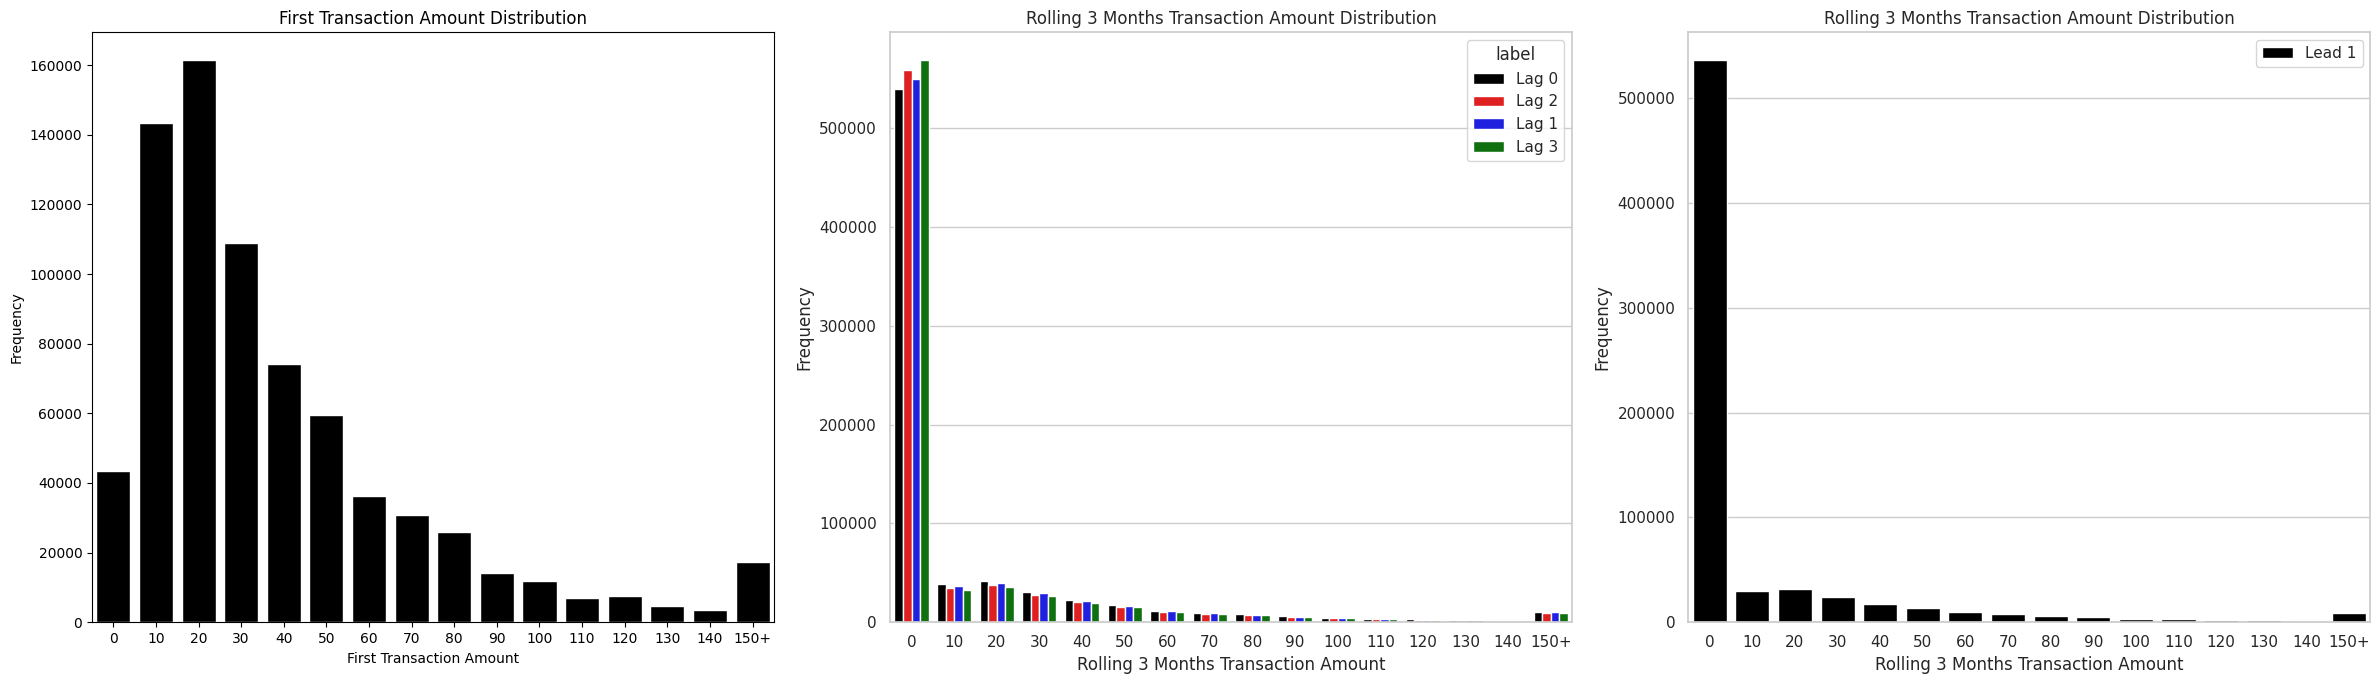

In [6]:
# Set the figure size
plt.figure(figsize=(24, 7))

###################################################################################
plt.subplot(131)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.first_trans_amt/10)*10)
        .assign(bin = lambda x:[int(value) if value < 150 else 150 for value in x.bin])
        .assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin', 'bin_label'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin_label",
    y="counter",
    color="black"
)
plt.xlabel('First Transaction Amount')
plt.ylabel('Frequency')
plt.title('First Transaction Amount Distribution')

###################################################################################
plt.subplot(132)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        pd.concat(
            [
              pd.DataFrame(cltv_tbl.trans_amt_R03m_lag0.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 0"),
              pd.DataFrame(cltv_tbl.trans_amt_R03m_lag1.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 1"),
              pd.DataFrame(cltv_tbl.trans_amt_R03m_lag2.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 2"),
              pd.DataFrame(cltv_tbl.trans_amt_R03m_lag3.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 3"),
            ], axis=0
        )
        .assign(bin = lambda x:[np.floor(value/10)*10 if value >= 0 else -1 for value in x.trans_amt_R03m])
        .assign(bin = lambda x:[int(value) if value < 150 else 150 for value in x.bin])
        .assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['label', 'bin', 'bin_label'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin_label",
    y="counter",
    hue="label",
    palette=["black", "red", "blue", "green"]
)
plt.xlabel('Rolling 3 Months Transaction Amount')
plt.ylabel('Frequency')
plt.title('Rolling 3 Months Transaction Amount Distribution')

###################################################################################
plt.subplot(133)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl[pd.to_datetime(cltv_tbl.ref_dt) <= cutoff]
        .assign(bin = lambda x:np.floor(x.trans_amt_R03m_lead1/10)*10)
        .assign(bin = lambda x:[int(value) if value < 150 else 150 for value in x.bin])
        .assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin', 'bin_label'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin_label",
    y="counter",
    color="black",
    label="Lead 1"
)
plt.xlabel('Rolling 3 Months Transaction Amount')
plt.ylabel('Frequency')
plt.title('Rolling 3 Months Transaction Amount Distribution')

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

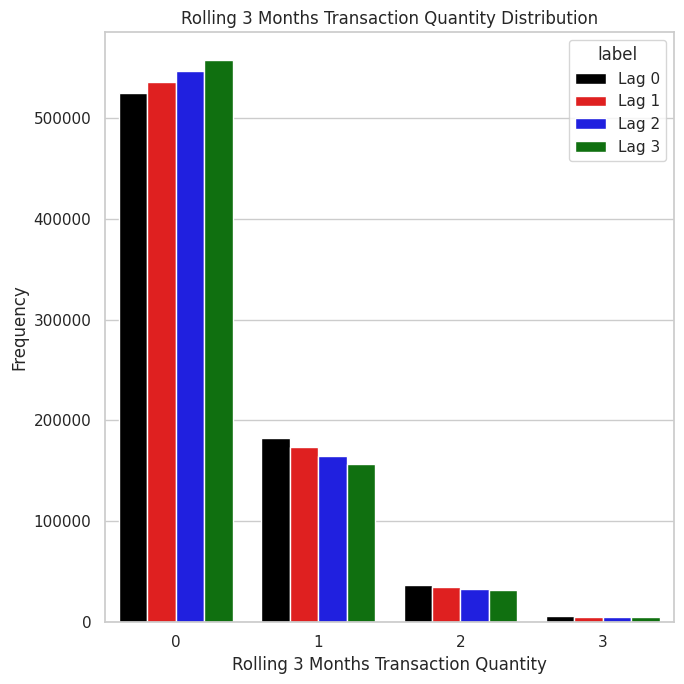

In [7]:
# Set the figure size
plt.figure(figsize=(7, 7))

###################################################################################
plt.subplot(111)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        pd.concat(
            [
              pd.DataFrame(cltv_tbl.trans_qnt_R03m_lag0.values, columns=['trans_qnt_R03m']).assign(label = lambda x: "Lag 0"),
              pd.DataFrame(cltv_tbl.trans_qnt_R03m_lag1.values, columns=['trans_qnt_R03m']).assign(label = lambda x: "Lag 1"),
              pd.DataFrame(cltv_tbl.trans_qnt_R03m_lag2.values, columns=['trans_qnt_R03m']).assign(label = lambda x: "Lag 2"),
              pd.DataFrame(cltv_tbl.trans_qnt_R03m_lag3.values, columns=['trans_qnt_R03m']).assign(label = lambda x: "Lag 3"),
            ], axis=0
        )
        .assign(bin = lambda x:x.trans_qnt_R03m)
        .assign(counter = lambda x:1)
        .groupby(['label', 'bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    hue="label",
    palette=["black", "red", "blue", "green"]
)
plt.xlabel('Rolling 3 Months Transaction Quantity')
plt.ylabel('Frequency')
plt.title('Rolling 3 Months Transaction Quantity Distribution')


# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

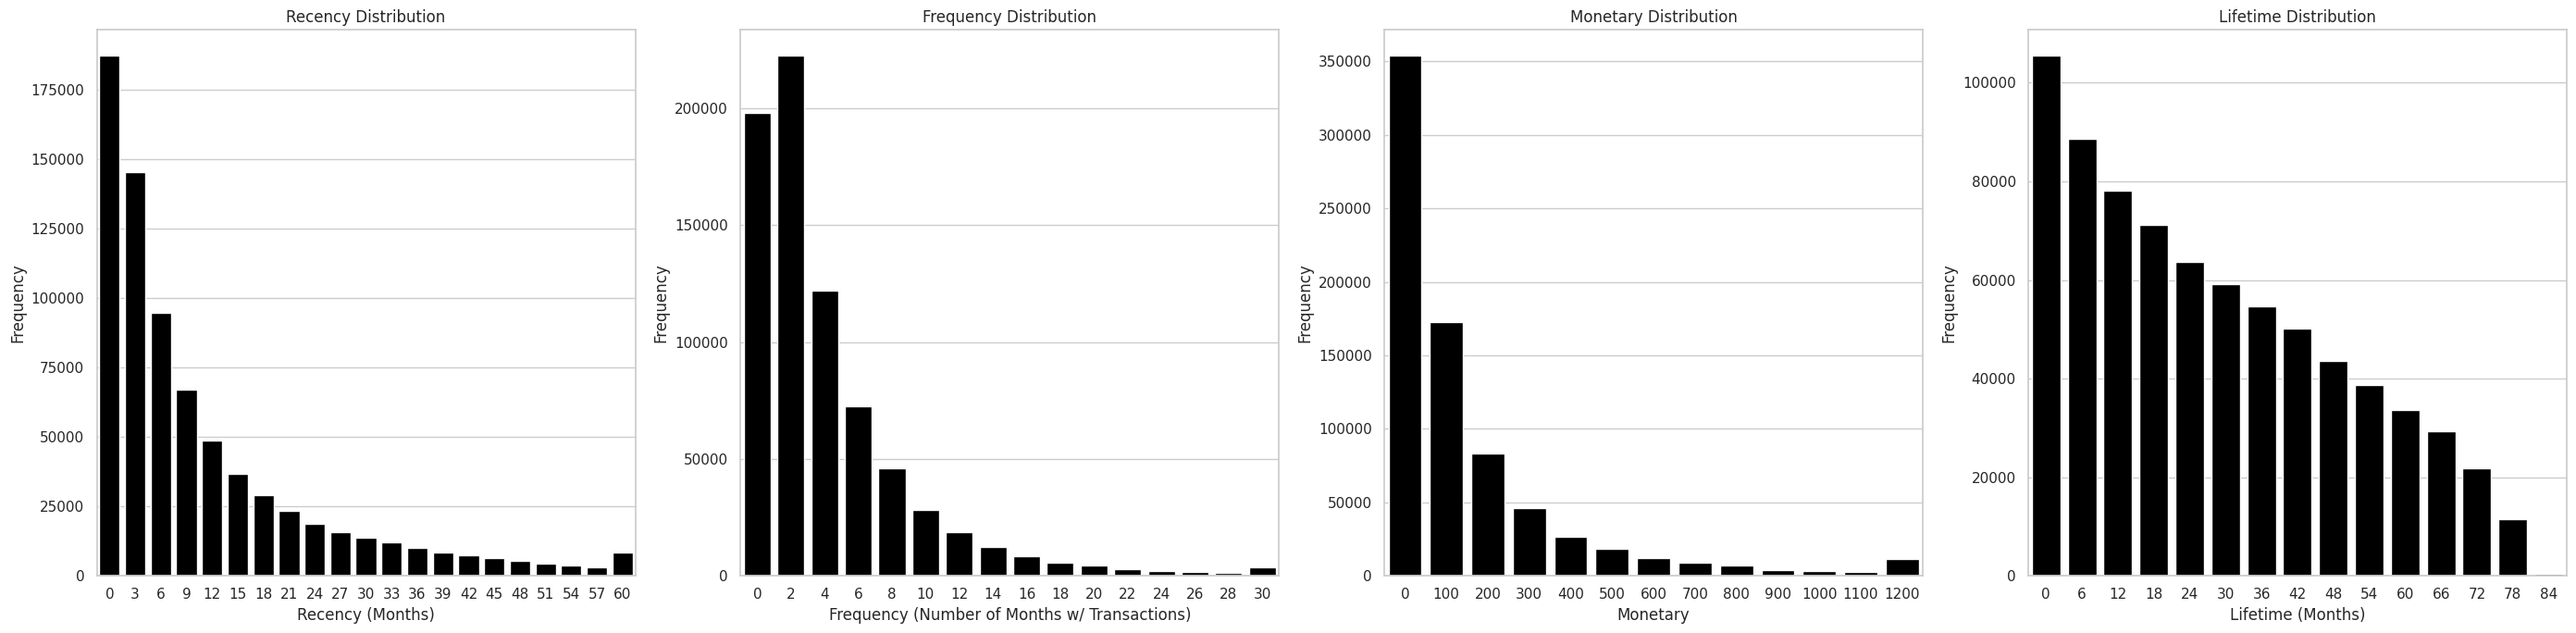

In [36]:
# Set the figure size
plt.figure(figsize=(28, 7))

###################################################################################
plt.subplot(141)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.recency/3)*3)
        .assign(bin = lambda x:[int(value) if value < 60 else 60 for value in x.bin])
        #.assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Recency (Months)')
plt.ylabel('Frequency')
plt.title('Recency Distribution')

###################################################################################
plt.subplot(142)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.frequency/2)*2)
        .assign(bin = lambda x:[int(value) if value < 30 else 30 for value in x.bin])
        #.assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Frequency (Number of Months w/ Transactions)')
plt.ylabel('Frequency')
plt.title('Frequency Distribution')

###################################################################################
plt.subplot(143)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.monetary/100)*100)
        .assign(bin = lambda x:[int(value) if value < 1200 else 1200 for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.title('Monetary Distribution')


###################################################################################
plt.subplot(144)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.lifetime/6)*6)
        .assign(bin = lambda x:[int(value) if value < 84 else 84 for value in x.bin])
        #.assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Lifetime (Months)')
plt.ylabel('Frequency')
plt.title('Lifetime Distribution')


# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

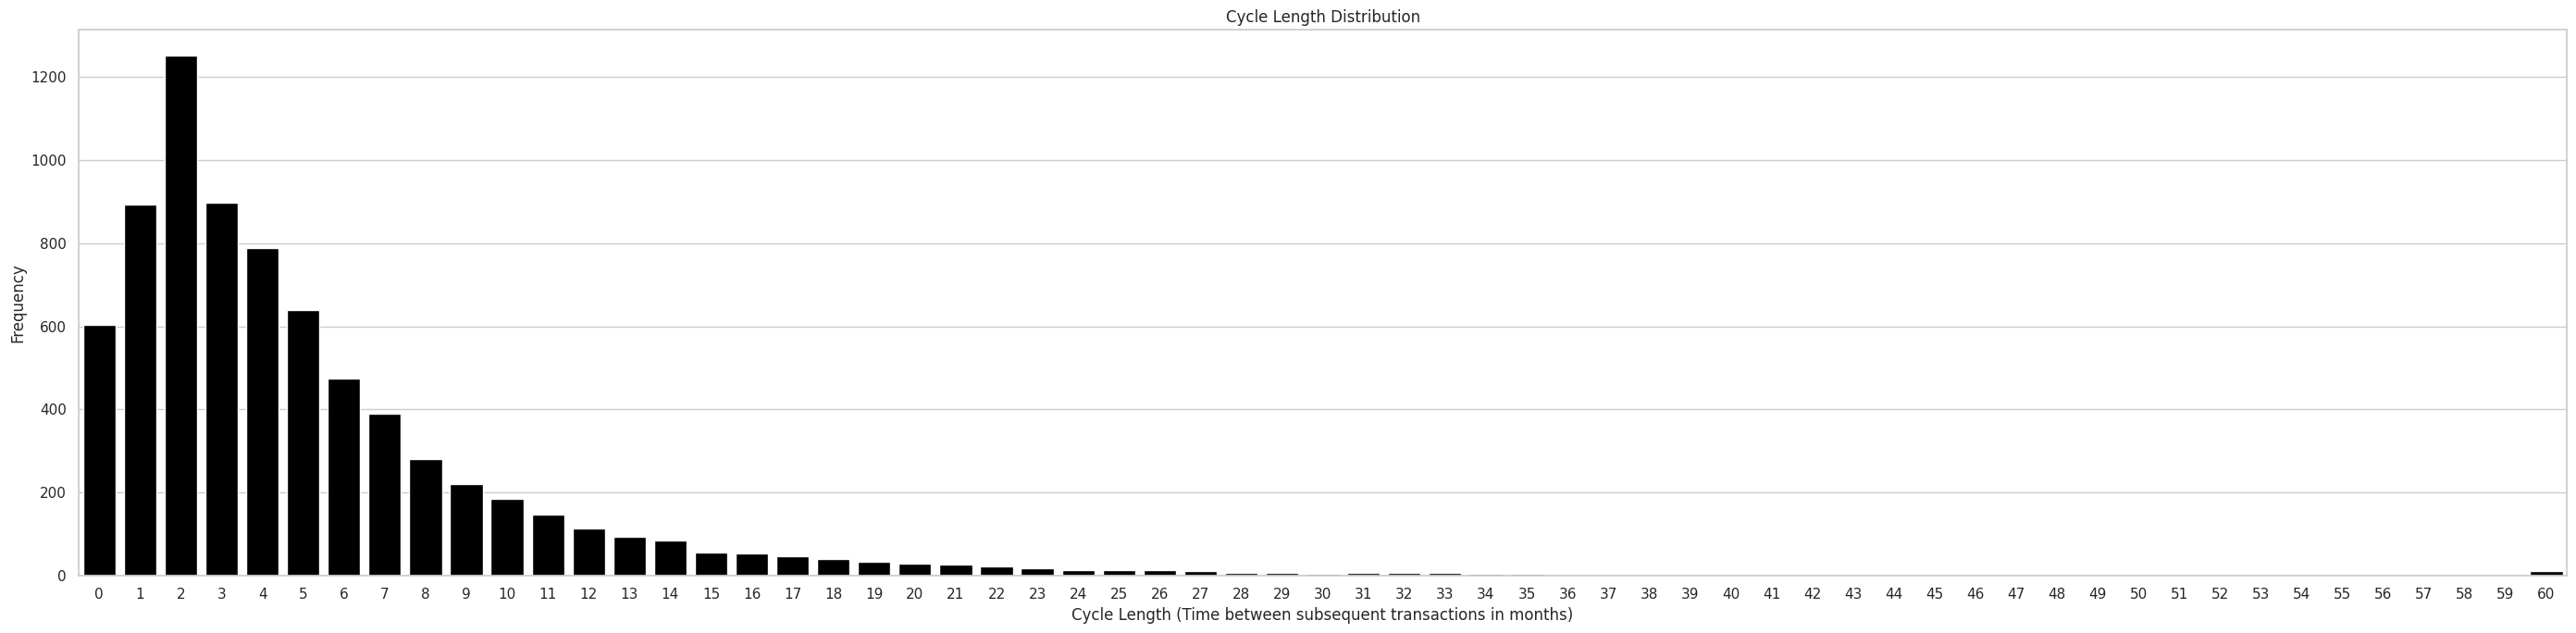

In [45]:
# Set the figure size
plt.figure(figsize=(28, 7))

###################################################################################
plt.subplot(111)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.cycle_length/1)*1)
        .assign(bin = lambda x:[int(value) if value < 60 else 60 for value in x.bin])
        #.assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Cycle Length (Time between subsequent transactions in months)')
plt.ylabel('Frequency')
plt.title('Cycle Length Distribution')

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

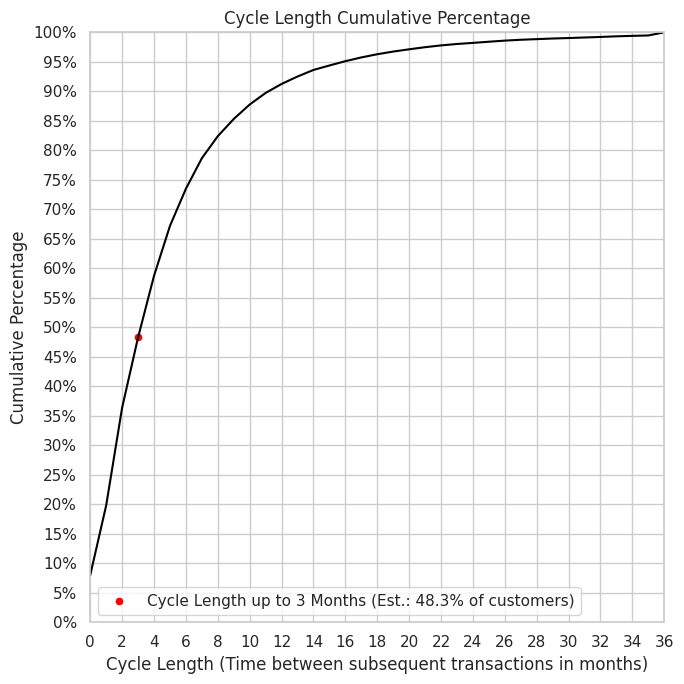

In [58]:
# Creating a dataframe with aggregated statistics on cycle length
cycle_length_tbl = (
  cltv_tbl
  .assign(bin = lambda x:np.floor(x.cycle_length/1)*1)
  .assign(bin = lambda x:[int(value) if value < 36 else 36 for value in x.bin])
  .assign(counter = lambda x:1)
  .groupby(['bin'])
  .agg({'counter':'sum'})
  .reset_index()
  .sort_values(by="bin")
  .assign(cumulative_percentage = lambda x:x.counter.cumsum()/x.counter.sum())
)

# Calculating the percentage of customers that have a cycle length of 3 months
pctg_trans_3m = cycle_length_tbl[cycle_length_tbl.bin==3].cumulative_percentage.values[0]

# Set the figure size
plt.figure(figsize=(7, 7))

###################################################################################
plt.subplot(111)
sns.set(style="whitegrid")
sns.lineplot(data=cycle_length_tbl, x="bin", y="cumulative_percentage", color="black")
sns.scatterplot(x=[3], y=[pctg_trans_3m], color="red", label=f"Cycle Length up to 3 Months (Est.: {np.round(100*pctg_trans_3m,1)}% of customers)")
plt.xlabel('Cycle Length (Time between subsequent transactions in months)')
plt.ylabel('Cumulative Percentage')
plt.title('Cycle Length Cumulative Percentage')

plt.xlim([0, 36])
plt.xticks(ticks=[0 + i*2 for i in range(19)])

plt.ylim([0, 1])
plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

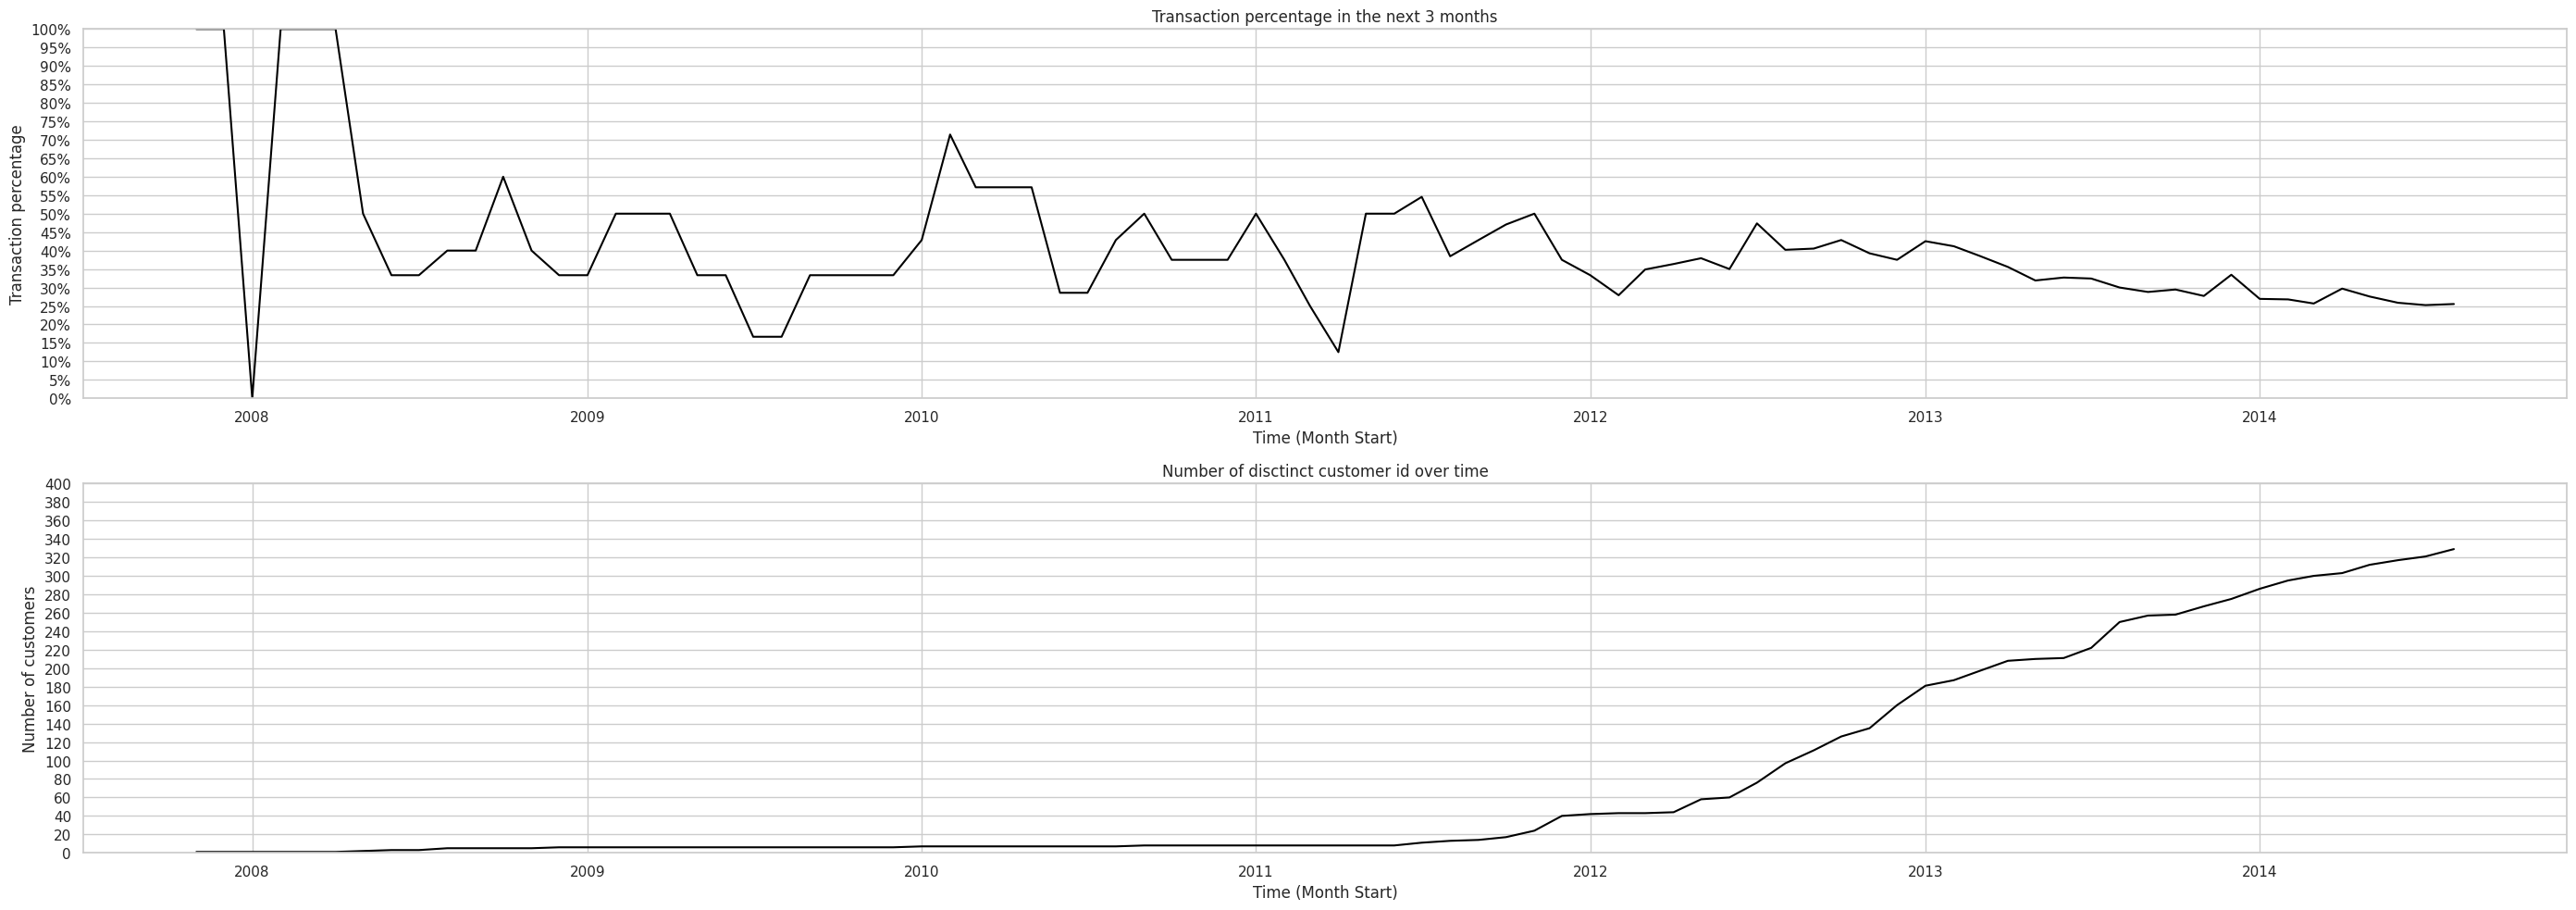

In [70]:
# Creating a transaction percentage in the next 3 months dataframe
trans_next_3m_tbl = (
    cltv_tbl[pd.to_datetime(cltv_tbl.ref_dt) <= cutoff]
    .assign(trans_next_3m = lambda x:np.where(x.trans_amt_R03m_lead1 > 0, 1, 0))
    .groupby(['ref_dt'])
    .agg({"trans_next_3m":"mean", "cust_id": lambda x: x.nunique()})
    .reset_index()
    .sort_values(by="ref_dt", ascending=True)

)


# Set the figure size
plt.figure(figsize=(28, 10))

###################################################################################
plt.subplot(211)
sns.set(style="whitegrid")
sns.lineplot(data=trans_next_3m_tbl, x="ref_dt", y="trans_next_3m", color="black")
#sns.scatterplot(x=[3], y=[pctg_trans_3m], color="red", label=f"Cycle Length up to 3 Months (Est.: {np.round(100*pctg_trans_3m,1)}% of customers)")
plt.xlabel('Time (Month Start)')
plt.ylabel('Transaction percentage')
plt.title('Transaction percentage in the next 3 months')

#plt.xlim([0, 36])
#plt.xticks(ticks=[0 + i*2 for i in range(19)])

plt.ylim([0, 1])
plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

###################################################################################
plt.subplot(212)
sns.set(style="whitegrid")
sns.lineplot(data=trans_next_3m_tbl, x="ref_dt", y="cust_id", color="black")
#sns.scatterplot(x=[3], y=[pctg_trans_3m], color="red", label=f"Cycle Length up to 3 Months (Est.: {np.round(100*pctg_trans_3m,1)}% of customers)")
plt.xlabel('Time (Month Start)')
plt.ylabel('Number of customers')
plt.title('Number of disctinct customer id over time')

plt.ylim([0, 400])
plt.yticks(ticks=[0 + i*20 for i in range(21)])


# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

## Feature Adjustments

In [73]:
cltv_tbl_adj_tbl = (

  # Referencing the customer lifetime value table
  cltv_tbl

  # Calculating the log(x+1) of the cycle length
  .assign(cycle_length = lambda x:np.log(x.cycle_length + 1))

  # Calculating the log(x+1) of the recency
  .assign(recency = lambda x:np.log(x.recency + 1))

  # Calculating the log(x+1) of the frequency
  .assign(frequency = lambda x:np.log(x.frequency + 1))

  # Calculating the log(x+1) of the monetary
  .assign(monetary = lambda x:np.log(x.monetary + 1))

  # Calculating the log(x+1) of the lifetime
  .assign(lifetime = lambda x:np.log(x.lifetime + 1))

  # Calculating the log(x+1) of the first_trans_amt
  .assign(first_trans_amt = lambda x:np.log(x.first_trans_amt + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag0
  .assign(trans_amt_R03m_lag0 = lambda x:np.log(x.trans_amt_R03m_lag0 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag1
  .assign(trans_amt_R03m_lag1 = lambda x:np.log(x.trans_amt_R03m_lag1 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag2
  .assign(trans_amt_R03m_lag2 = lambda x:np.log(x.trans_amt_R03m_lag2 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag3
  .assign(trans_amt_R03m_lag3 = lambda x:np.log(x.trans_amt_R03m_lag3 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag3
  .assign(trans_amt_R03m_lead1 = lambda x:np.log(x.trans_amt_R03m_lead1 + 1))

)

cltv_tbl_adj_tbl[features + ['trans_amt_R03m_lead1']].describe()

,first_trans_amt,cycle_length,recency,frequency,monetary,lifetime,trans_qnt_R03m_lag0,trans_qnt_R03m_lag1,trans_qnt_R03m_lag2,trans_qnt_R03m_lag3,trans_amt_R03m_lag0,trans_amt_R03m_lag1,trans_amt_R03m_lag2,trans_amt_R03m_lag3,trans_amt_R03m_lead1
count,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000
mean,3.389067,1.662247,1.757913,1.242861,4.276836,2.367614,0.508484,0.463415,0.415429,0.364793,1.457222,1.325052,1.184553,1.042971,1.036238
std,0.744098,0.710527,0.781251,0.561425,1.015577,0.909736,0.685783,0.670974,0.654181,0.628343,1.816461,1.780042,1.734355,1.677243,1.672268
min,1.599387,0.000000,0.000000,0.693147,1.599387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.887590,1.193715,1.132727,0.693147,3.550479,1.831595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.363495,1.639874,1.717370,1.098612,4.234106,2.534132,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.867025,2.112866,2.326943,1.609438,4.987366,3.029803,1.000000,1.000000,1.000000,1.000000,3.326833,3.210843,3.039770,2.763169,2.760800
max,5.863631,4.277085,4.282320,3.526361,7.270556,4.444004,3.000000,3.000000,3.000000,3.000000,6.648724,6.648724,6.648724,6.648724,6.648724


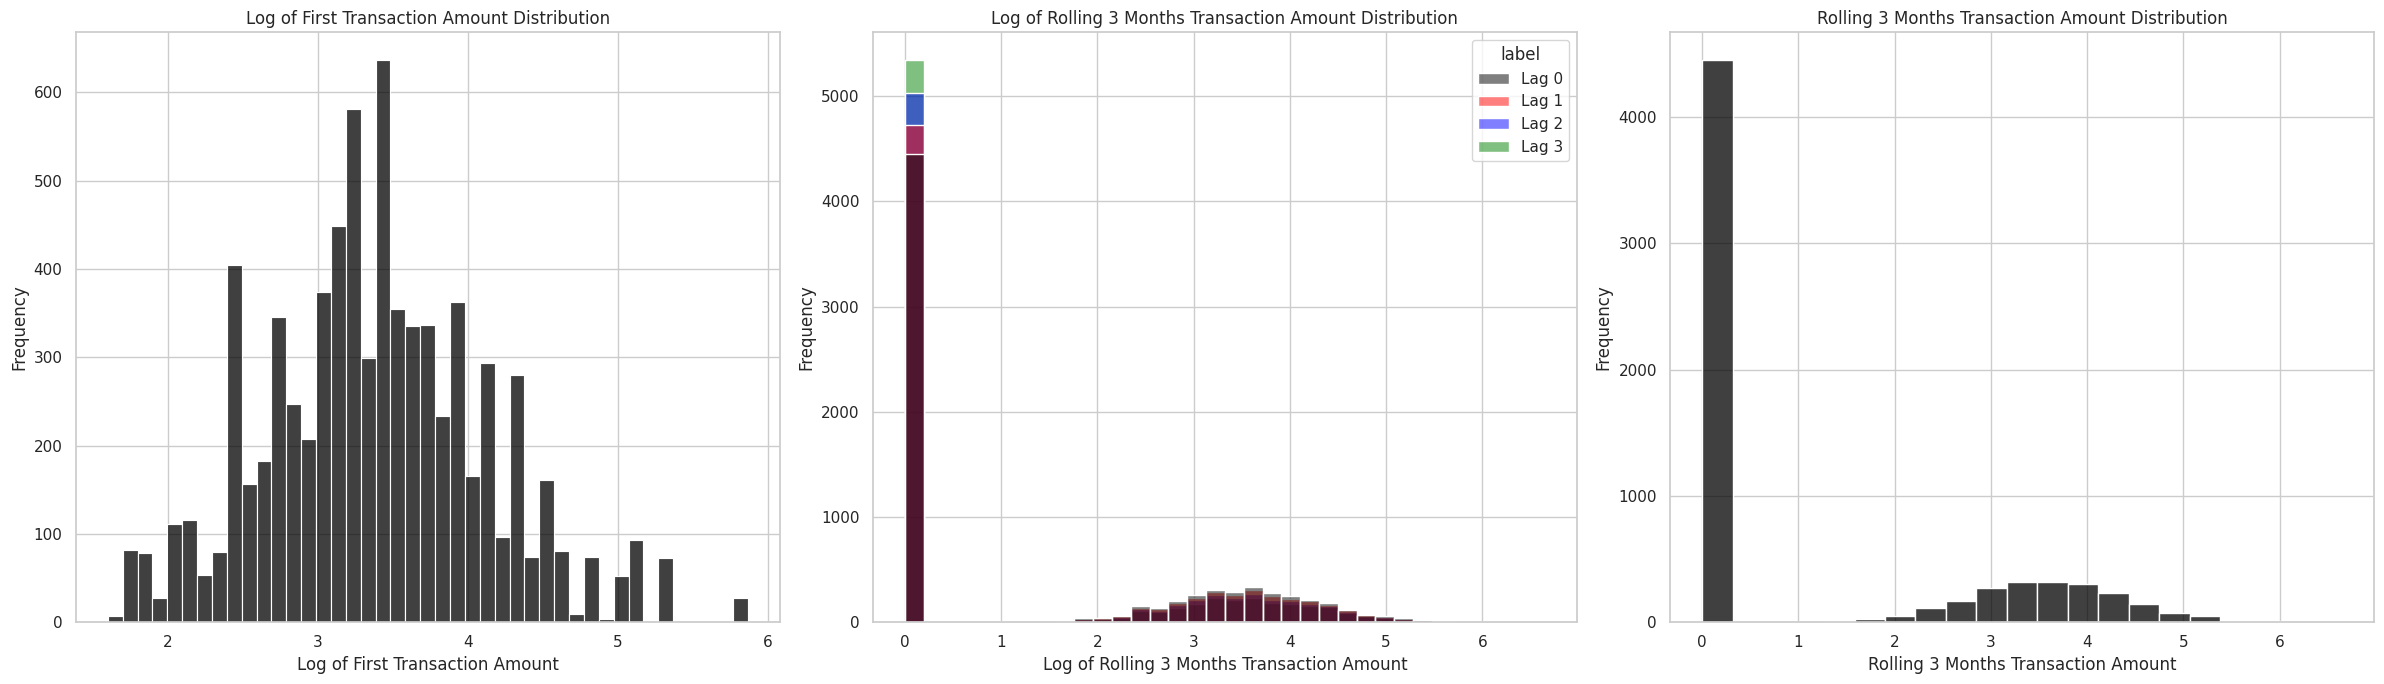

In [78]:
# Set the figure size
plt.figure(figsize=(24, 7))

###################################################################################
plt.subplot(131)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="first_trans_amt", color="black")
plt.xlabel('Log of First Transaction Amount')
plt.ylabel('Frequency')
plt.title('Log of First Transaction Amount Distribution')

###################################################################################
plt.subplot(132)
sns.set(style="whitegrid")
sns.histplot(
    data=(
        pd.concat(
            [
              pd.DataFrame(cltv_tbl_adj_tbl.trans_amt_R03m_lag0.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 0"),
              pd.DataFrame(cltv_tbl_adj_tbl.trans_amt_R03m_lag1.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 1"),
              pd.DataFrame(cltv_tbl_adj_tbl.trans_amt_R03m_lag2.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 2"),
              pd.DataFrame(cltv_tbl_adj_tbl.trans_amt_R03m_lag3.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 3"),
            ], axis=0
        )
    ),
    x="trans_amt_R03m",
    hue="label",
    palette=["black", "red", "blue", "green"]
)
plt.xlabel('Log of Rolling 3 Months Transaction Amount')
plt.ylabel('Frequency')
plt.title('Log of Rolling 3 Months Transaction Amount Distribution')

###################################################################################
plt.subplot(133)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl[pd.to_datetime(cltv_tbl_adj_tbl.ref_dt) <= cutoff], x="trans_amt_R03m_lead1", color="black", label="Lead 1")
plt.xlabel('Rolling 3 Months Transaction Amount')
plt.ylabel('Frequency')
plt.title('Rolling 3 Months Transaction Amount Distribution')

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

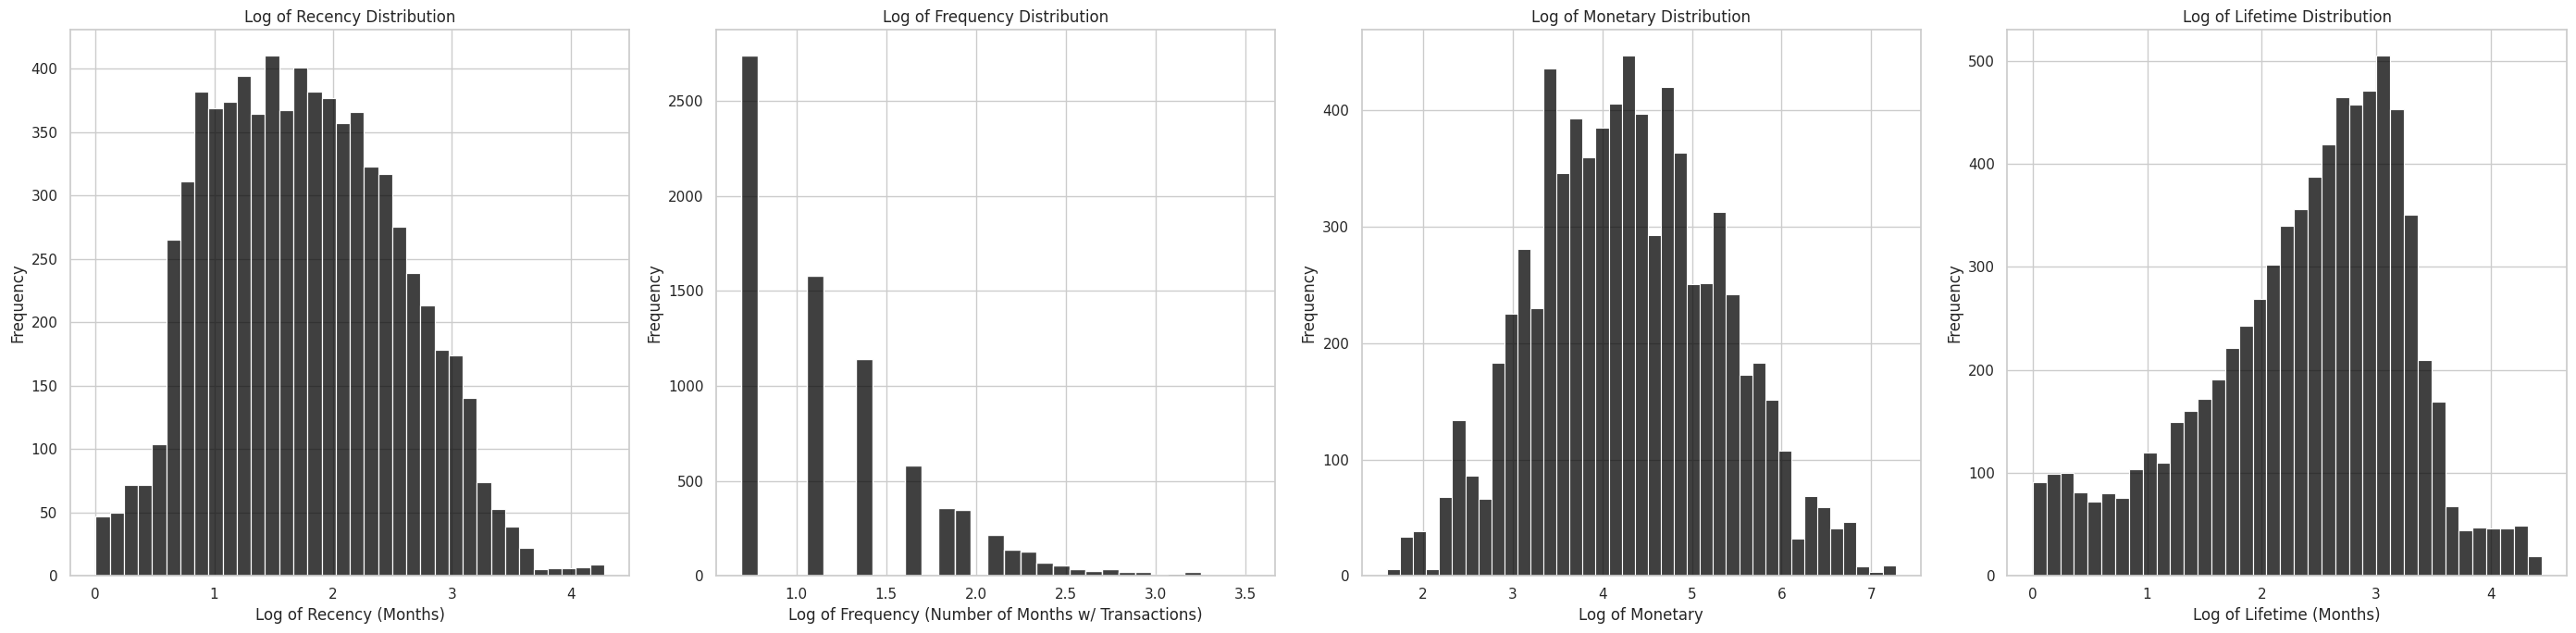

In [79]:
# Set the figure size
plt.figure(figsize=(28, 7))

###################################################################################
plt.subplot(141)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="recency", color="black")
plt.xlabel('Log of Recency (Months)')
plt.ylabel('Frequency')
plt.title('Log of Recency Distribution')

###################################################################################
plt.subplot(142)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="frequency", color="black")
plt.xlabel('Log of Frequency (Number of Months w/ Transactions)')
plt.ylabel('Frequency')
plt.title('Log of Frequency Distribution')

###################################################################################
plt.subplot(143)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="monetary", color="black")
plt.xlabel('Log of Monetary')
plt.ylabel('Frequency')
plt.title('Log of Monetary Distribution')


###################################################################################
plt.subplot(144)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="lifetime", color="black")
plt.xlabel('Log of Lifetime (Months)')
plt.ylabel('Frequency')
plt.title('Log of Lifetime Distribution')


# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

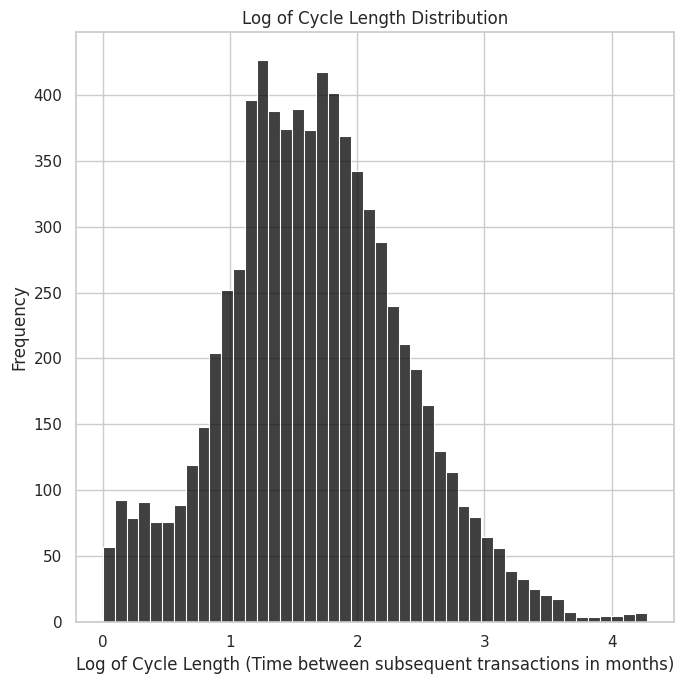

In [80]:
# Set the figure size
plt.figure(figsize=(7, 7))

###################################################################################
plt.subplot(111)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="cycle_length", color="black")
plt.xlabel('Log of Cycle Length (Time between subsequent transactions in months)')
plt.ylabel('Frequency')
plt.title('Log of Cycle Length Distribution')

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

In [81]:
cltv_tbl.cycle_length.std()

6.221389385155839

In [82]:
cltv_tbl_adj_tbl = (

  # Referencing the customer lifetime value table
  cltv_tbl

  # Calculating the z-score of the cycle length
  .assign(cycle_length = lambda x:(x.cycle_length - x.cycle_length.mean())/x.cycle_length.std())

  # Calculating the z-score of the recency
  .assign(recency = lambda x:(x.recency - x.recency.mean())/x.recency.std())

  # Calculating the log(x+1) of the frequency
  .assign(frequency = lambda x:np.log(x.frequency + 1))

  # Calculating the log(x+1) of the monetary
  .assign(monetary = lambda x:np.log(x.monetary + 1))

  # Calculating the z-score of the lifetime
  .assign(lifetime = lambda x:(x.lifetime - x.lifetime.mean())/x.lifetime.std())

  # Calculating the log(x+1) of the first_trans_amt
  .assign(first_trans_amt = lambda x:np.log(x.first_trans_amt + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag0
  .assign(trans_amt_R03m_lag0 = lambda x:np.log(x.trans_amt_R03m_lag0 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag1
  .assign(trans_amt_R03m_lag1 = lambda x:np.log(x.trans_amt_R03m_lag1 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag2
  .assign(trans_amt_R03m_lag2 = lambda x:np.log(x.trans_amt_R03m_lag2 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag3
  .assign(trans_amt_R03m_lag3 = lambda x:np.log(x.trans_amt_R03m_lag3 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag3
  .assign(trans_amt_R03m_lead1 = lambda x:np.log(x.trans_amt_R03m_lead1 + 1))

)

cltv_tbl_adj_tbl[features + ['trans_amt_R03m_lead1']].describe()

,first_trans_amt,cycle_length,recency,frequency,monetary,lifetime,trans_qnt_R03m_lag0,trans_qnt_R03m_lag1,trans_qnt_R03m_lag2,trans_qnt_R03m_lag3,trans_amt_R03m_lag0,trans_amt_R03m_lag1,trans_amt_R03m_lag2,trans_amt_R03m_lag3,trans_amt_R03m_lead1
count,7544.000000,7544.000000,7.544000e+03,7544.000000,7544.000000,7.544000e+03,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000
mean,3.389067,0.000000,-7.534918e-18,1.242861,4.276836,6.027934e-17,0.508484,0.463415,0.415429,0.364793,1.457222,1.325052,1.184553,1.042971,1.036238
std,0.744098,1.000000,1.000000e+00,0.561425,1.015577,1.000000e+00,0.685783,0.670974,0.654181,0.628343,1.816461,1.780042,1.734355,1.677243,1.672268
min,1.599387,-0.945706,-9.694550e-01,0.693147,1.599387,-1.156427e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.887590,-0.576123,-6.750901e-01,0.693147,3.550479,-7.247829e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.363495,-0.277926,-3.301313e-01,1.098612,4.234106,-2.011272e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.867025,0.223152,3.241406e-01,1.609438,4.987366,4.646055e-01,1.000000,1.000000,1.000000,1.000000,3.326833,3.210843,3.039770,2.763169,2.760800
max,5.863631,10.471380,9.020552e+00,3.526361,7.270556,5.767465e+00,3.000000,3.000000,3.000000,3.000000,6.648724,6.648724,6.648724,6.648724,6.648724


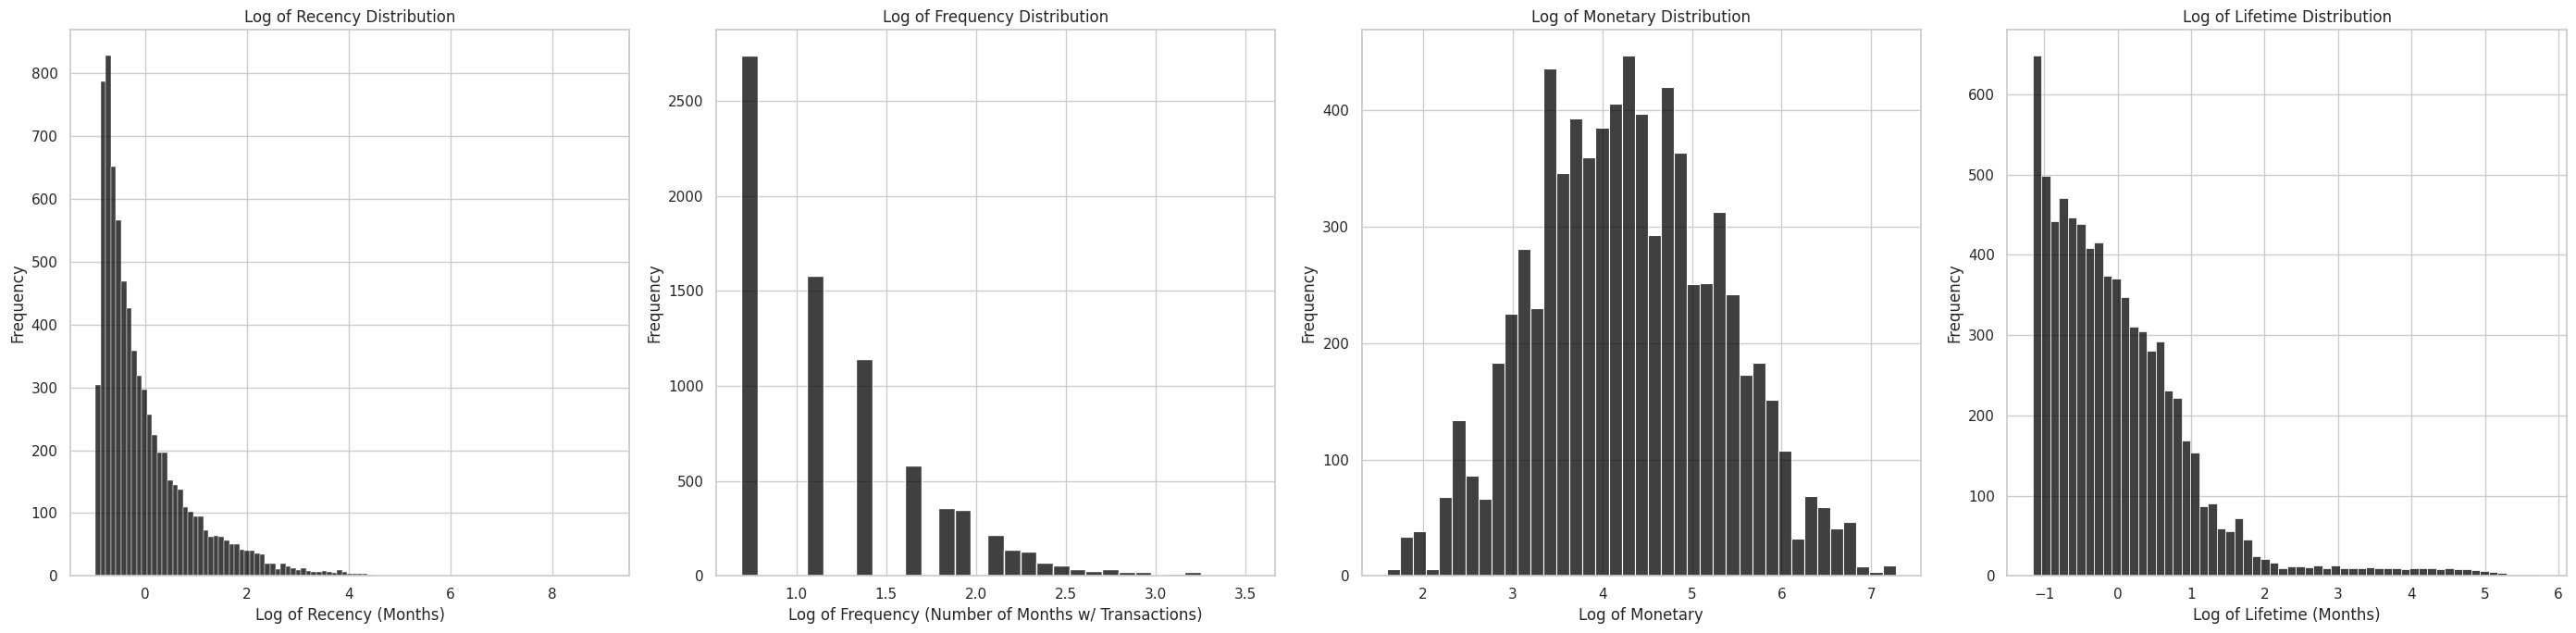

In [83]:
# Set the figure size
plt.figure(figsize=(28, 7))

###################################################################################
plt.subplot(141)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="recency", color="black")
plt.xlabel('Log of Recency (Months)')
plt.ylabel('Frequency')
plt.title('Log of Recency Distribution')

###################################################################################
plt.subplot(142)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="frequency", color="black")
plt.xlabel('Log of Frequency (Number of Months w/ Transactions)')
plt.ylabel('Frequency')
plt.title('Log of Frequency Distribution')

###################################################################################
plt.subplot(143)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="monetary", color="black")
plt.xlabel('Log of Monetary')
plt.ylabel('Frequency')
plt.title('Log of Monetary Distribution')


###################################################################################
plt.subplot(144)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="lifetime", color="black")
plt.xlabel('Log of Lifetime (Months)')
plt.ylabel('Frequency')
plt.title('Log of Lifetime Distribution')


# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

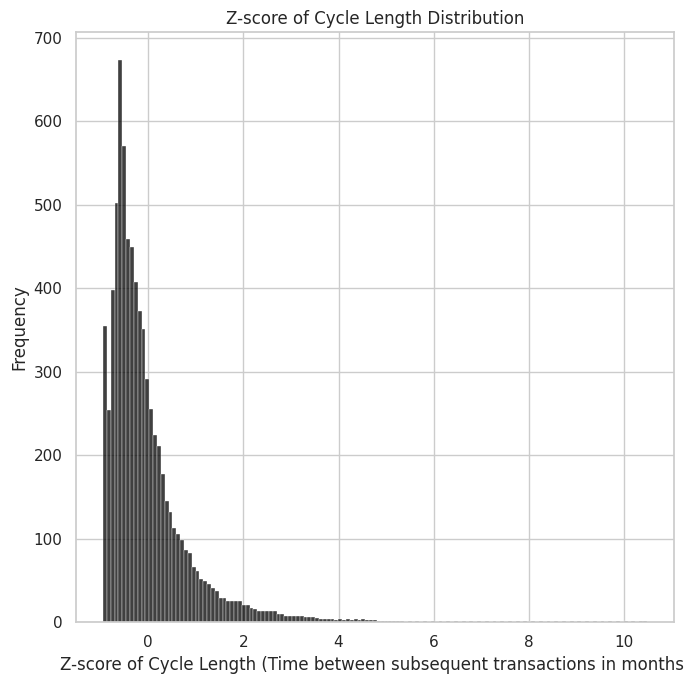

In [85]:
# Set the figure size
plt.figure(figsize=(7, 7))

###################################################################################
plt.subplot(111)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="cycle_length", color="black")
plt.xlabel('Z-score of Cycle Length (Time between subsequent transactions in months)')
plt.ylabel('Frequency')
plt.title('Z-score of Cycle Length Distribution')

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()